In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [17]:
# Load the dataset
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

df = pd.read_csv('adult.data',header = None, names = col_names)

# Clean columns by stripping extra whitespace for columns of type "object"
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()
display(df.head())

# Check Class Imbalance
print(df.income.value_counts(normalize=True))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


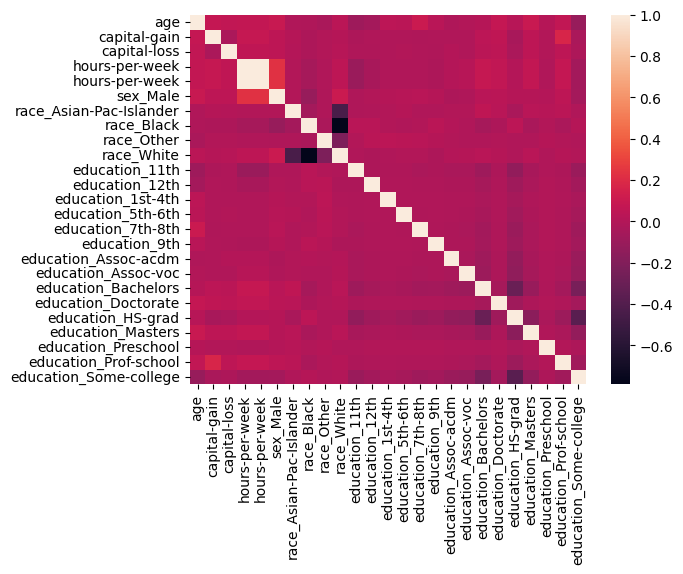

In [18]:
# Create feature dataframe X with feature columns and dummy variables for categorical features
feature_cols = ['age','capital-gain', 'capital-loss', 'hours-per-week', 'sex','race', 'hours-per-week', 'education']
X = pd.get_dummies(df[feature_cols], drop_first=True)

# Create a heatmap of X data to see feature correlation
plt.figure()
sns.heatmap(X.corr())#, annot=True)
plt.show()
plt.close()


 Model Parameters, Intercept:
-5.565240905371425

 Model Parameters, Coeff:
[[ 3.66193160e-02  3.14695357e-04  6.66239707e-04  1.99441527e-02
   1.19996341e-02  1.02960204e+00  0.00000000e+00 -3.62373265e-01
   0.00000000e+00  7.35683421e-02 -5.78150225e-01  0.00000000e+00
   0.00000000e+00 -4.03551378e-01 -8.98043759e-01 -5.03531273e-01
   5.70192977e-01  5.44773180e-01  1.27985962e+00  1.79542449e+00
   0.00000000e+00  1.59673580e+00  0.00000000e+00  1.82068562e+00
   3.82267264e-01]]

 Confusion Matrix on test set:
[[4778  248]
 [ 880  607]]

 Accuracy Score on test set: 0.8268079226163059
                       var      coef
14       education_7th-8th -0.898044
10          education_11th -0.578150
15           education_9th -0.503531
13       education_5th-6th -0.403551
7               race_Black -0.362373
1             capital-gain  0.000315
2             capital-loss  0.000666
4           hours-per-week  0.012000
3           hours-per-week  0.019944
0                      age  0

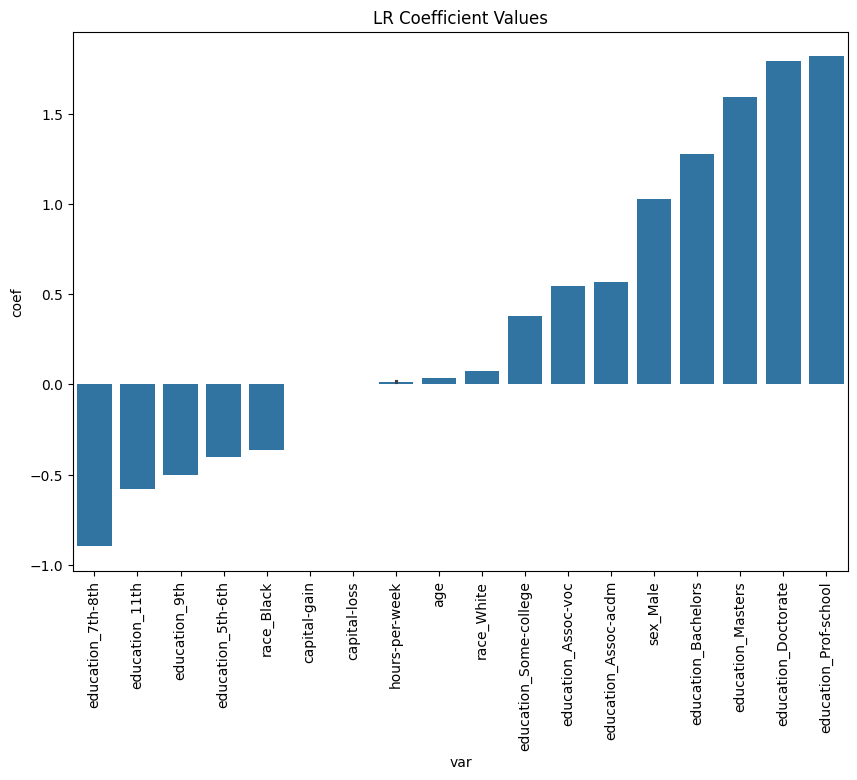

ROC AUC score: 0.845609956671843


In [19]:
# Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greater than 50k
y = np.where(df.income=='<=50K', 0, 1)

# Split data into a train and test set
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=.2)

# Fit LR model with sklearn on train set, and predicting on the test set
log_reg = LogisticRegression(C=0.05, penalty='l1', solver='liblinear')
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

# Print model parameters (intercept and coefficients)
print('\n Model Parameters, Intercept:')
print(log_reg.intercept_[0])
print('\n Model Parameters, Coeff:')
print(log_reg.coef_)

# Evaluate the predictions of the model on the test set. Print the confusion matrix and accuracy score.
print('\n Confusion Matrix on test set:')
print(confusion_matrix(y_test, y_pred))
print(f'\n Accuracy Score on test set: {log_reg.score(x_test, y_test)}')

# Create new DataFrame of the model coefficients and variable names; sort values based on coefficient
coef_df = pd.DataFrame(zip(x_train.columns, log_reg.coef_[0]), columns=['var', 'coef']).sort_values('coef')
coef_df = coef_df[coef_df.coef.abs()>0].sort_values('coef')
print(coef_df)

# Barplot of the coefficients sorted in ascending order
plt.figure(figsize = (10,7))
sns.barplot(data=coef_df, x='var', y='coef')
plt.xticks(rotation=90);
plt.title('LR Coefficient Values')
plt.show()
plt.close()

# Plot the ROC curve and print the AUC value.
y_pred_prob = log_reg.predict_proba(x_test)
roc_auc = roc_auc_score(y_test, y_pred_prob[:,1])
print(f'ROC AUC score: {roc_auc}')


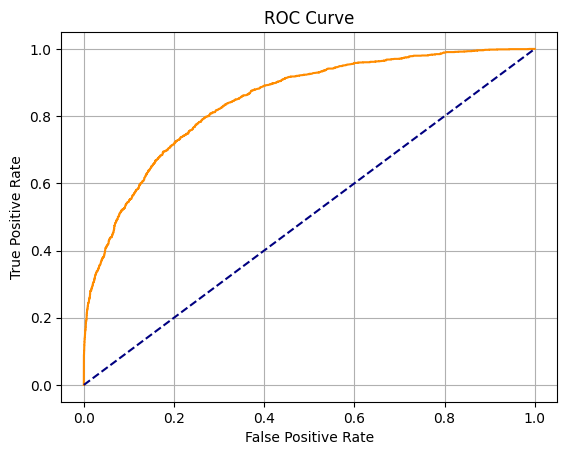

In [20]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1], color='navy',linestyle='--')
plt.title('ROC Curve')
plt.grid()
plt.show()